<a href="https://colab.research.google.com/github/Brendromero/ProyectSteamGame/blob/main/ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Limpieza de datos**


In [ ]:
import pandas as pd
import json
from ast import literal_eval
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# **I. El problema del negocio**

Trabajamos como Data Scientist en Steam, una plataforma multinacional de videojuegos y se nos ha encargado hacer un sistema de recomendacion de videojuegos para los usuarios.

Sin embargo, nos encontramos con los datos impuros. Asi que nuestro primer trabajo sera limpiar esos datos, transformarlos para un analisis mas profundo y hacer el sistema de recomendacion adecuadamente.

# **II. El set de los datos**

La información que se nos ha entregado son 3 .json.gz lo cual descomprimi anteriormente:


*   [australian_users_items.json](https://drive.google.com/file/d/1hHvKZHEa4Fyj-nWdF_fq5c28_YRhEBwb/view?usp=drive_link):
Este archivo contiene 5 columnas(user_id, items_count, steam_id, user_url e items -este ultimo tiene datos anidados-)

*   [australian_user_reviews.json](https://drive.google.com/file/d/1-EokrFjVKgZ6XXOuUV4C350dE5jIAv0v/view?usp=drive_link):
Este archivo contiene 3 columnas(user_id, user_url y reviews -este ultimo tiene datos anidados)

*   [output_steam_games.json](https://drive.google.com/file/d/11avqC7AbkFOz4IcXftBRa8CZpR4znoTb/view?usp=drive_link):
Este archivo contiene 15 columnas(publisher, genres, app_name, title, url, release_date, tags, discount_price, reviews_url, specs, price, early_access, id, developer, metascore)

* [Diccionario de datos](https://docs.google.com/spreadsheets/d/1NSlZocD5t3Mq3RaUudMmt_s8hwfQBB85/edit?usp=drive_link&ouid=117731322330287463270&rtpof=true&sd=true):
Este archivo contiene información necesaria para conocer y trabajar con los JSON entregados.

In [ ]:
#Me conecto con google colab a mi drive para trabajar con los datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **II.I Lectura del json 'items'**

In [ ]:
#Creo una lista vacia para luego poder agregar los datos que sacamos del dataset
row = []

with open('/content/drive/MyDrive/Datasets_entregados/australian_users_items.json', encoding="latin1") as f:
    for lines in f.readlines():
        row.append(ast.literal_eval(lines))
#Lo convierto en dataframe para visualizar mejor los datos
df_items = pd.DataFrame(row) #2min 9s

In [ ]:
print(df_items.shape)
df_items.head()
#Vemos la columna de reviews que tiene datos anidados

(88310, 5)


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [ ]:
#Veo cuales son las variables numericas y categoricas
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


## **II.II Desanidar los datos necesarios**

Desde nuestro diccionario y como ya he mencionado más arriba, debemos desanidar la columna 'items'. Veamos la información que nos brinda:



1.   user_id: identificador único de usuario
2.   user_url: URl de perfil del usuario
3.   items_count: Cantidad de items por usuario
4.   items: items de usuario ('iteam_id': identificador único del juego, 'item_name': nombre del juego, 'playtime_forever': horas jugadas, 'playtime_2weeks': horas jugadas dentro de las 2 semanas)

Observando las columnas que tenemos y basandome a lo que nos piden en el sistema de recomendación, tomare dos columnas de alli que considero importante para mi análisis:

*   item_id
*   item_name
*   playtime_forever


In [ ]:
data_desanidada = []

for index, row in df_items.iterrows():
    user_id = row['user_id']
    items_count = row['items_count']
    steam_id = row['steam_id']
    user_url = row['user_url']
    items = row['items']

    for i in items:
        new_rows = {
            'user_id': user_id,
            'items_count': items_count,
            'steam_id': steam_id,
            'user_url': user_url,
            'item_id': i.get('item_id', ''),
            'item_name': i.get('item_name', ''),
            'playtime_forever': i.get('playtime_forever', '')
        }
        data_desanidada.append(new_rows)

items_desanidado = pd.DataFrame(data_desanidada) #demora 14s

In [ ]:
items_desanidado.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0


In [ ]:
items_desanidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   items_count       int64 
 2   steam_id          object
 3   user_url          object
 4   item_id           object
 5   item_name         object
 6   playtime_forever  int64 
dtypes: int64(2), object(5)
memory usage: 275.2+ MB


In [ ]:
print(f'tamanio del set antes de eliminar las filas repetidas: {items_desanidado.shape}')
items_desanidado.drop_duplicates(inplace=True)
print(f'tamanio del set despues de eliminar las filas repetidas: {items_desanidado.shape}')

tamanio del set antes de eliminar las filas repetidas: (5153209, 7)
tamanio del set despues de eliminar las filas repetidas: (5094092, 7)


## **II.III Outliers en las variables numéricas**

No siempre se deben eliminar los outliers porque dependiendo de la variable numérica analizada estos pueden contener información importante.

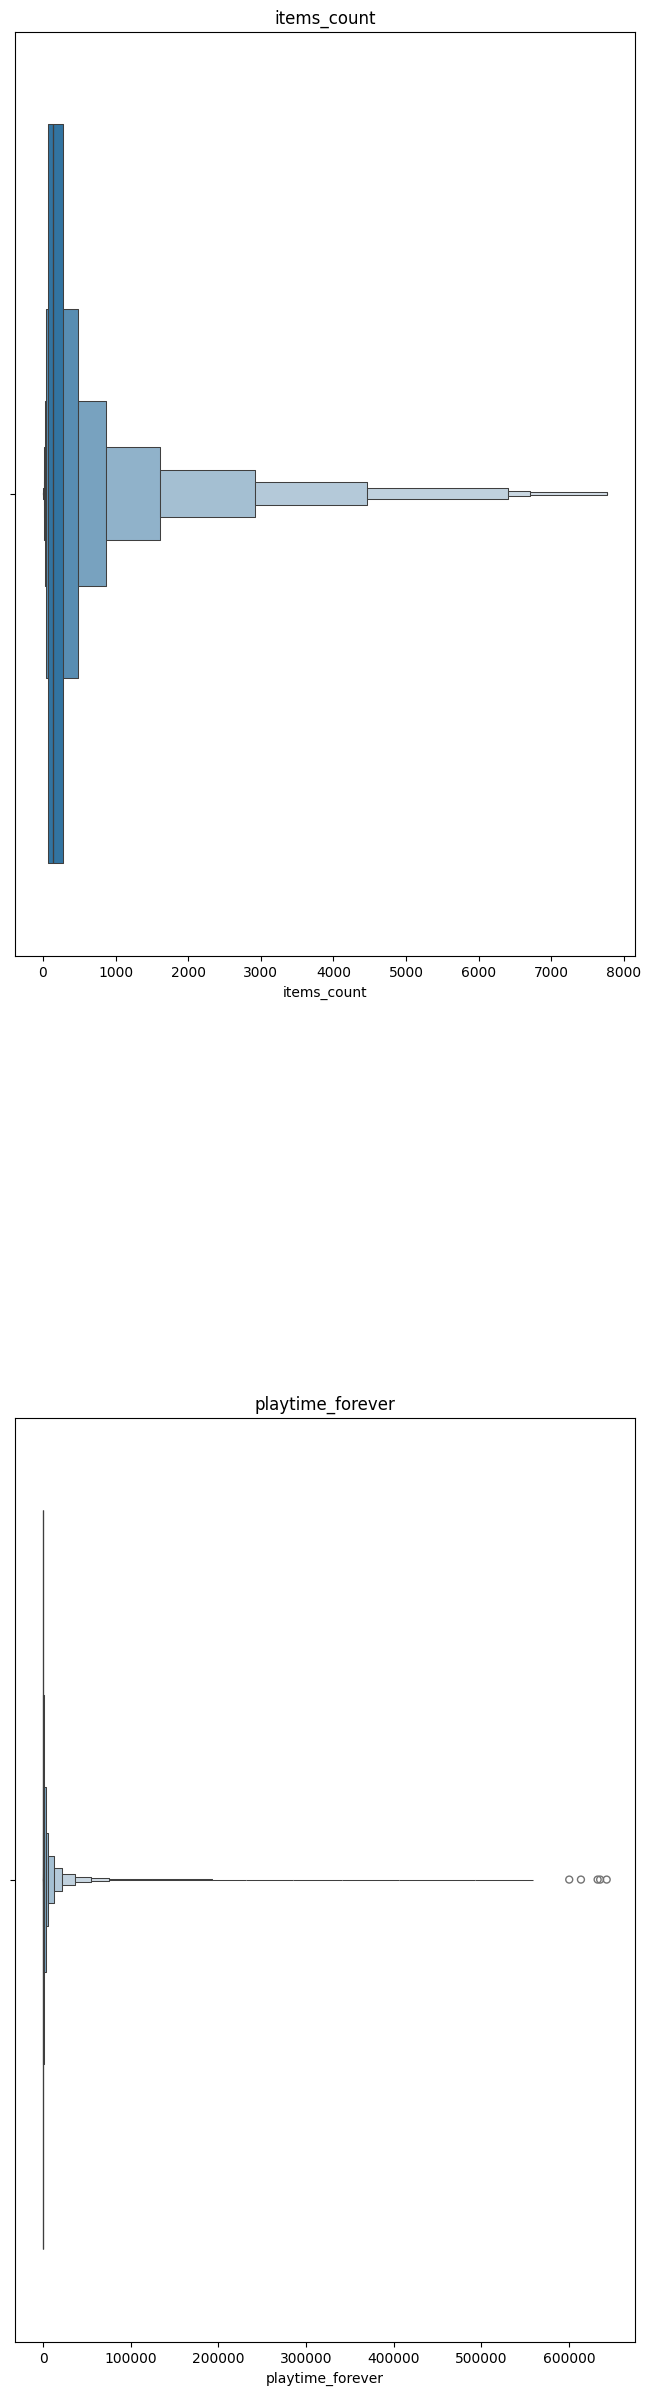

In [ ]:
cols_num = ['items_count', 'playtime_forever']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i , col in enumerate(cols_num):
  sns.boxenplot(x=col, data=items_desanidado, ax=ax[i])
  ax[i].set_title(col) #Demora 10s

En la visualización de arriba podemos observar en 'playtime_forever' que hay resultados que salen de lo común dentro de los jugadores.

Teniendo conocimiento de que la plataforma esta desde 2003 y haciendo el siguiente cálculo:

(365 * 24) / 600000 = 68.4 años

Esto sin tener en cuanta los años bisiestos. Por lo que esos datos estan mal porque la plataforma tiene poco mas de 21 años. Y calculando que jugaran las 24 horas del dia  por 21 años, estariamos llegando a los 183.960 horas

In [ ]:
#Vamos a resudir esos datos a 100.000 horas
print(f'Tamaño del set antes de eliminar datos:{items_desanidado.shape}')
items1 = items_desanidado[items_desanidado['playtime_forever']<= 100000]
print(f'Tamaño del set despues de eliminar datos: {items1.shape}')

Tamaño del set antes de eliminar datos:(5094092, 7)
Tamaño del set despues de eliminar datos: (5091662, 7)


# **III. Lectura del archivo json 'Reviews'**

In [ ]:
row = []

with open('/content/drive/MyDrive/Datasets_entregados/australian_user_reviews.json', encoding="latin1") as f:
    for lines in f.readlines():
        row.append(ast.literal_eval(lines))

df_reviews = pd.DataFrame(row)

In [ ]:
print(df_reviews.shape)
df_reviews.head()
#Vemos la columna de reviews que tiene datos anidados

(25799, 3)


,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [ ]:
#Veo cuales son las variables numericas y categoricas
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


## **III.I Desanidar los datos**

Asi como hicimos con los datos de 'items', aca debemos hacer el mismo procedimiento con la columna 'reviews'. Veamos que tenemos en cada columna que nos pueda servir para nuestro sistema de recomendación:

1.   user_id: identificador único de usuario
2.   user_url: url del perfil del usuario
3.   reviews: reviews de usuario('funny': sin datos que especifiquen a que se refiere, 'posted': contiene fecha en formato de texto y numérico, 'last_edited': sin especificar datos, 'item_id': identificador único del juego, 'helpful': parece ser un porcentaje de los comentarios sobre el juego, 'recommend': datos booleanos, 'reviews': comentarios positivos, neutrales o negativos sobre el juego)

In [ ]:
data_desanidada = []

for index, row in df_reviews.iterrows():
    user_id = row['user_id']
    user_url = row['user_url']
    reviews = row['reviews']

    for i in reviews:
        new_row = {
        'user_id': user_id,
        'user_url' : user_url,
        'posted': i.get('posted', ''),
        'item_id': i.get('item_id', ''),
        'recommend': i.get('recommend', ''),
        'sentiment_analysis': i.get('review', ''),
        }
    data_desanidada.append(new_row)

reviews_desanidado = pd.DataFrame(data_desanidada)

In [ ]:
reviews_desanidado.head()

,user_id,user_url,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
1,js41637,http://steamcommunity.com/id/js41637,"Posted November 29, 2013.",239030,True,Very fun little game to play when your bored o...
2,evcentric,http://steamcommunity.com/id/evcentric,"Posted October 15, 2014.",224500,True,"Fun world builder, with plenty of option of ho..."
3,doctr,http://steamcommunity.com/id/doctr,"Posted February 23, 2012.",108710,True,"Alan wake is a really good game, the light eff..."
4,maplemage,http://steamcommunity.com/id/maplemage,"Posted July 11, 2013.",204300,True,"OH YES, THIS GAME IS THE BEST, THEY ADD STUFF ..."


## **III.II Analisis de sentimiento**

Uno de los endpoints que se pide para el sistema de recomendación es reemplazar la columna de review por la de sentiment_analysis. Veamos en trabajar con la columna 'sentiment_analysis' donde se pide usar NLP para aplicar un análisis de sentimiento
* '0' si es negativo,
* '1' si es neutral,
* '2' si es positivo

In [ ]:
# Eliminamos los valos NaN en la columna review
reviews_desanidado = reviews_desanidado[reviews_desanidado['sentiment_analysis'].notna()]

# o rellenar con valores NaN con una cadena vacia o un texto default
reviews_desanidado['sentiment_analysis'].fillna('', inplace=True)

In [ ]:
#Voy a iniciar usando vader para el analisis de sentimiento

sia = SentimentIntensityAnalyzer(lexicon_file='/content/drive/MyDrive/datasets/vader_lexicon.txt')

#agregamos Vader a las metricas del dataframe
reviews_desanidado['compound'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['compound'])
reviews_desanidado['neg'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['neg'])
reviews_desanidado['neu'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['neu'])
reviews_desanidado['pos'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['pos'])

In [ ]:
reviews_copy = reviews_desanidado.copy()
#Funcion para categorizarr el sentimiento segun la puntiacion compuesta
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 2
    elif compound <= 0.05:
        return 0
    else:
        return 1

reviews_copy['sentiment_analysis'] = reviews_copy['compound'].apply(categorize_sentiment)

reviews_copy

,user_id,user_url,posted,item_id,recommend,sentiment_analysis,compound,neg,neu,pos
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted April 21, 2011.",43110,True,2,0.9117,0.000,0.704,0.296
1,js41637,http://steamcommunity.com/id/js41637,"Posted November 29, 2013.",239030,True,2,0.7713,0.081,0.541,0.378
2,evcentric,http://steamcommunity.com/id/evcentric,"Posted October 15, 2014.",224500,True,2,0.5106,0.093,0.643,0.264
3,doctr,http://steamcommunity.com/id/doctr,"Posted February 23, 2012.",108710,True,2,0.9571,0.000,0.738,0.262
4,maplemage,http://steamcommunity.com/id/maplemage,"Posted July 11, 2013.",204300,True,2,0.9939,0.071,0.313,0.616
...,...,...,...,...,...,...,...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,Posted May 31.,261030,True,2,0.8015,0.161,0.493,0.345
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,Posted June 17.,730,True,0,0.0000,0.000,1.000,0.000
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,Posted June 23.,570,True,2,0.2732,0.000,0.323,0.677
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,Posted July 8.,362890,True,2,0.9786,0.026,0.692,0.282


In [ ]:
reviews_copy = reviews_copy.drop(['compound', 'neg', 'neu', 'pos'], axis=1)
reviews_copy

,user_id,user_url,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted April 21, 2011.",43110,True,2
1,js41637,http://steamcommunity.com/id/js41637,"Posted November 29, 2013.",239030,True,2
2,evcentric,http://steamcommunity.com/id/evcentric,"Posted October 15, 2014.",224500,True,2
3,doctr,http://steamcommunity.com/id/doctr,"Posted February 23, 2012.",108710,True,2
4,maplemage,http://steamcommunity.com/id/maplemage,"Posted July 11, 2013.",204300,True,2
...,...,...,...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,Posted May 31.,261030,True,2
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,Posted June 17.,730,True,0
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,Posted June 23.,570,True,2
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,Posted July 8.,362890,True,2


Transformemos la columna 'posted' en un formato que podamos trabajar mas adelante con el sistema de recomendación. Se crea una columna llamada 'release_date' para almacenar lo siguiente.

Tomamos la columna de posted y aplicamos una funcion llamada 'lambda' que toma una entrada x y con re la usa para sustituir todas las apariciones de la palabra posted y puntos en x. El strip elimina cualquier espacio en blanco que haya al principio o final.

In [ ]:
reviews_copy['release_date'] = reviews_copy['posted'].apply(lambda x: re.sub(r'Posted|\.', '', x).strip())
countreviews = reviews_copy[['user_id','item_id', 'recommend', 'sentiment_analysis', 'release_date']].copy()
#La columna clean_date, usando to_datetime lo convertiamos en una fecha
countreviews['release_date'] = pd.to_datetime(reviews_copy['release_date'], errors='coerce')

# se convierte en formato de fecha y nuevamente a una cadena de formato 'yyyy-mm-dd'
countreviews['release_date'] = countreviews['release_date'].dt.strftime('%Y-%m-%d')

In [ ]:
countreviews.head()

,user_id,item_id,recommend,sentiment_analysis,release_date
0,76561197970982479,43110,True,2,2011-04-21
1,js41637,239030,True,2,2013-11-29
2,evcentric,224500,True,2,2014-10-15
3,doctr,108710,True,2,2012-02-23
4,maplemage,204300,True,2,2013-07-11


In [ ]:
#Vamos a tomar las columnas categoricas
cols_cat = ['user_id', 'item_id', 'release_date']
for col in cols_cat:
  print(f'Columna {col}: {countreviews[col].nunique()} subniveles')

Columna user_id: 25458 subniveles
Columna item_id: 2163 subniveles
Columna release_date: 1520 subniveles


# **IV. Lectura de los datos 'games'**

In [ ]:
row = []

with open('/content/drive/MyDrive/Datasets_entregados/output_steam_games.json') as f:
  for line in f:
    try:
      json_data = json.loads(line)
      row.append(json_data)
    except json.JSONDecodeError:
      print(f'Error decoding JSON: {line}')

df_games = pd.DataFrame(row)

In [ ]:
print(df_games.shape)
df_games.head()

(120445, 13)


,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


## **IV.I Renombrar columna**

En este caso a diferencia de los otros archivos, no tenemos columnas que esten anidadas. Sin embargo vimos que gran parte de los datos eran de tipo NaN.

Ahora lo que voy a hacer es, en base a los endpoints que tengo que generar para mi sistema de recomendación,
voy a tomar las columnas necesarias.

Pero antes, voy a renombrar 'id' por 'item_id' para facilitar luego el merge.

In [ ]:
output = df_games.rename(columns={'id': 'item_id'})

# **V. Crear CSV con los 3 archivos**

Antes comenzar con la etapa del EDA, se nos será más cómodo poder trabajar con un único archivo donde solo contenga las columnas que necesitamos para nuestro sistema de recomendación.

Por lo que de todas las columnas vamos a necesitar:

'items_desanidado'
*   user_id
*   item_id
*   items_count
*   item_name
*   playtime_forever

'countreviews'
*   user_id
*   item_id
*   recommend
*   sentiment_analysis

'output'

*   item_id
*   release_date
*   genres
*   price
*   title
*   developer

## Columnas por las que vamos a unirlas

*   item_id
*   user_id





In [ ]:
item = items1[['item_id', 'user_id','items_count', 'item_name', 'playtime_forever']]
print(item.shape)
item.head()

(5091662, 5)


,item_id,user_id,items_count,item_name,playtime_forever
0,10,76561197970982479,277,Counter-Strike,6
1,20,76561197970982479,277,Team Fortress Classic,0
2,30,76561197970982479,277,Day of Defeat,7
3,40,76561197970982479,277,Deathmatch Classic,0
4,50,76561197970982479,277,Half-Life: Opposing Force,0


In [ ]:
review = countreviews[['item_id', 'user_id', 'recommend', 'sentiment_analysis']]
print(review.shape)
review.head()

(25799, 4)


,item_id,user_id,recommend,sentiment_analysis
0,43110,76561197970982479,True,2
1,239030,js41637,True,2
2,224500,evcentric,True,2
3,108710,doctr,True,2
4,204300,maplemage,True,2


In [ ]:
games = output[['item_id', 'genres','price', 'title', 'developer', 'release_date']]
print(games.shape)
games.head()

(120445, 6)


,item_id,genres,price,title,developer,release_date
0,None,None,None,None,None,None
1,None,None,None,None,None,None
2,None,None,None,None,None,None
3,None,None,None,None,None,None
4,None,None,None,None,None,None


In [ ]:
game = games.dropna()
game

,item_id,genres,price,title,developer,release_date
88310,761140,"[Action, Casual, Indie, Simulation, Strategy]",4.99,Lost Summoner Kitty,Kotoshiro,2018-01-04
88311,643980,"[Free to Play, Indie, RPG, Strategy]",Free To Play,Ironbound,Secret Level SRL,2018-01-04
88312,670290,"[Casual, Free to Play, Indie, Simulation, Sports]",Free to Play,Real Pool 3D - Poolians,Poolians.com,2017-07-24
88313,767400,"[Action, Adventure, Casual]",0.99,弹炸人2222,彼岸领域,2017-12-07
88315,772540,"[Action, Adventure, Simulation]",3.99,Battle Royale Trainer,Trickjump Games Ltd,2018-01-04
...,...,...,...,...,...,...
120439,745400,"[Action, Adventure, Casual, Indie]",1.99,Kebab it Up!,Bidoniera Games,2018-01-04
120440,773640,"[Casual, Indie, Simulation, Strategy]",1.99,Colony On Mars,"Nikita ""Ghost_RUS""",2018-01-04
120441,733530,"[Casual, Indie, Strategy]",4.99,LOGistICAL: South Africa,Sacada,2018-01-04
120442,610660,"[Indie, Racing, Simulation]",1.99,Russian Roads,Laush Dmitriy Sergeevich,2018-01-04


In [ ]:
# Convertir la columna 'item_id' en el DataFrame 'item' a tipo str
item['item_id'] = item['item_id'].astype(str)

df_cols = pd.merge(review, item, on=['item_id', 'user_id'], how='left')
df_cols

<ipython-input-60-c21435eabcaa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['item_id'] = item['item_id'].astype(str)


,item_id,user_id,recommend,sentiment_analysis,items_count,item_name,playtime_forever
0,43110,76561197970982479,True,2,277.0,Metro 2033,834.0
1,239030,js41637,True,2,888.0,"Papers, Please",349.0
2,224500,evcentric,True,2,137.0,Gnomoria,13618.0
3,108710,doctr,True,2,541.0,Alan Wake,1185.0
4,204300,maplemage,True,2,629.0,Awesomenauts,17589.0
...,...,...,...,...,...,...,...
25794,261030,76561198306599751,True,2,7.0,The Walking Dead: Season Two,795.0
25795,730,Ghoustik,True,0,4.0,Counter-Strike: Global Offensive,3969.0
25796,570,76561198310819422,True,2,NaN,NaN,NaN
25797,362890,76561198312638244,True,2,36.0,Black Mesa,2184.0


In [ ]:
#Vamos a unir las columnas con merge de pandas
# Convertir la columna 'item_id' en el DataFrame 'game' a tipo str
game['item_id'] = game['item_id'].astype(str)

# Unir los DataFrames usando la columna 'item_id'
df_columns = pd.merge(df_cols, game,on='item_id', how='left')

<ipython-input-64-361561bd9d03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game['item_id'] = game['item_id'].astype(str)


In [ ]:
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25799 entries, 0 to 25798
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             25799 non-null  object 
 1   user_id             25799 non-null  object 
 2   recommend           25799 non-null  bool   
 3   sentiment_analysis  25799 non-null  int64  
 4   items_count         18209 non-null  float64
 5   item_name           18209 non-null  object 
 6   playtime_forever    18209 non-null  float64
 7   genres              21698 non-null  object 
 8   price               21698 non-null  object 
 9   title               21698 non-null  object 
 10  developer           21698 non-null  object 
 11  release_date        21698 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 2.4+ MB


In [ ]:
df_columns

In [ ]:
#Convierto ese dataframe en un archivo csv para poder trabajar desde la API
csv_file_path = '/content/drive/MyDrive/datasets/new_steam_games.csv'
df_columns.to_csv(csv_file_path, index=False)

# **VI. Resumen de lo analizado**

## Nos hemos encontrado con datos que estaban anidados y que al desanidarlos comenzaban a pesar mucho. Esto para nuestra API iba a ser uno de los principales problemas contando que con GitHub tendriamos restricciones y tendriamos que instalar algunas cosas para eso. Al final el sistema de recomendación podia fallar para nosotros a la hora de crearlo, para el usuario y eso no terminaria siendo eficiente para nuestro modelo.

## A la hora de unir las columnas, tenia una idea de poder unir desde release_date en review y games, pero eso borraba gran parte de los datos importantes y eso no iba a servir para la API ya que solo quedaba con 3 columnas con datos, por lo que decidi descartar la columna de review y mantener la de games.

## Por ultimo, les dejare este [link](https://colab.research.google.com/drive/1OkOX1Eyi3R6kQQTVqVq85-wq5Hh3ELnJ) donde podran ver la siguiente etapa (EDA) donde anallizaré más gráficamente.